## とりあえずデータを見ていくnotebook

【このコンペの目標】
* よくあるBERTくらいを見ないで書けるようになること
    * mecab + bertのcl-tohokuとか --

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import MeCab
import re
import demoji, mojimoji
import neologdn

from config import *

### データ読み込み

In [367]:
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df.head(2)

,id,source,text,label
0,80074aa43,news4vip,まともに相手されてない人との関係なんて\nそんな大事にするものか？,0.0
1,6378fea6b,livejupiter,最近はアヘアヘQSマンやない？ ｲｲ!(・∀・)+1-0(・Ａ・)ｲｸﾅｲ!,0.0


In [368]:
(df.shape, train.shape, test.shape)

((8479, 4), (5256, 4), (3223, 3))

### タスク確認
* Stratified KFold

In [369]:
_t = pd.DataFrame(
    train[label_name].value_counts()
)
_t["pct[%]"] = np.round(train[label_name].value_counts()/train.shape[0]*100., 1)
display(_t); del _t

,label,pct[%]
0,4950,94.2
1,306,5.8


* ソースの存在比はtrain-testで大差なし

In [370]:
source_df = pd.DataFrame(train["source"].value_counts()).rename(columns={"source": "train"})
source_df["test"] = test["source"].value_counts()
source_df["train_pct[%]"] = np.round(source_df["train"]/source_df["train"].sum()*100., 1)
source_df["test_pct[%]"] = np.round(source_df["test"]/source_df["test"].sum()*100., 1)
source_df

,train,test,train_pct[%],test_pct[%]
newsplus,1967,1245,37.4,38.6
news4vip,1849,1141,35.2,35.4
livejupiter,1440,837,27.4,26.0


### 気持ちnews4vipからのヘイトスピーチが多いが、そもそも少ないのでどうだ？という感じ

In [371]:
train.groupby("source")[label_name].value_counts()

source       label
livejupiter  0        1356
             1          84
news4vip     0        1712
             1         137
newsplus     0        1882
             1          85
Name: label, dtype: int64

## textを正規化

In [372]:
def clean_text(text: str) -> str:
    """
    日本語から記号とかを削除
    タスク・与えられたデータによって適宜見ながらやるしかなさそう
    絵文字が鬼門という印象あり --

    <参考>
    * https://note.com/narudesu/n/na35de30a583a
    
    """
    # 改行コード削除 --
    text = text.replace("\n", "").replace("\r", "")

    # 半角-全角の正規化 --
    text = neologdn.normalize(text)

    # URL削除 --
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text)
    text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text)    

    # 絵文字の削除 --
    text = demoji.replace(string=text, repl="")

    # 記号系の削除(半角, 全角) --
    text = re.sub(r'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]', '', text)
    text = re.sub("[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)

    return text

In [373]:
df["clean_text"] = df["text"].map(lambda x: clean_text(x))

## 8000なら全数調査できそう
(感想)
* demojiは思ったほど絵文字をシバけない
* 

In [374]:
pd.set_option("display.max_rows", 200)
display(df.loc[:, ["source", "label", "clean_text"]])

,source,label,clean_text
0,news4vip,0.0,まともに相手されてない人との関係なんてそんな大事にするものか?
1,livejupiter,0.0,最近はアヘアヘQSマンやない? イイ!(・∀・)+1-0(・A・)イクナイ!
2,livejupiter,1.0,日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ甘えるな
3,livejupiter,0.0,よくよく思えば川上は配布にしたらとんでもなく有能だよなガチャから引いたら圧倒的歓喜レベルやで
4,newsplus,0.0,押井は原作レイプの専門家だから原作マンガの真意を誤解させることに関してはプロだがそれ以外には...
...,...,...,...
8474,news4vip,NaN,1人がいいのか?なんで変なのと同棲したのか…なにがしたいんだ…
8475,newsplus,NaN,ロシアもだなあ元北朝鮮はロシアの工作で作られた国だから
8476,newsplus,NaN,クネが国境に拡声器を設置して昼も夜も北の悪口鳴らしてんだとよお互い当たらないように大砲撃ち合...
8477,news4vip,NaN,当然って言い方が腹立つんだよなあその時点で何か男より優位に立ちたいみたいな感じがしてくるんだ...


In [375]:
#df[["source", "label", "clean_text"]].to_csv("./tmp_cleaned_text.csv", encoding="utf_8_sig", index=False)

### 文字数とlabelの関係はあんまなさそう

In [376]:
# 文字数のカウント --
df["count_char"] = df["clean_text"].map(lambda x: len(x))

Text(0.5, 1.0, 'Num of Charactor Histgram with legend-(Normal(0), Hate(1))')

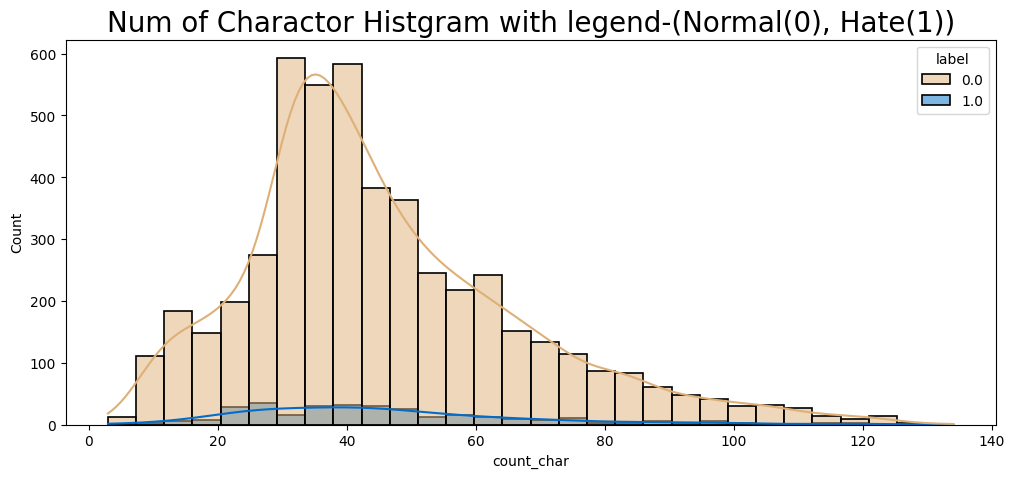

In [377]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.histplot(
    x="count_char", hue=label_name, data=df.loc[:train.shape[0], :],
    linewidth=1.2, palette=pal[::-1], kde=True, fill=True, bins=30,
)
ax.set_title("Num of Charactor Histgram with legend-(Normal(0), Hate(1))", fontsize=20)

### pd.DataFrameのDisplayはカラム幅に制限あるから、...は文字じゃなくて単に表示しきれていないことに注意

In [378]:
df.loc[df["count_char"].sort_values(ascending=False).head(10).index, :]

,id,source,text,label,clean_text,count_char
3836,a459d3a34,livejupiter,学歴別ガチャ引いて出てきた新卒に正社員養成プログラム受けさせるのが一番、採用教育コスト安く上...,0.0,学歴別ガチャ引いて出てきた新卒に正社員養成プログラム受けさせるのが一番採用教育コスト安く上が...,134
5479,123b58842,newsplus,中韓への謝罪はなかったけど日本がハルノートを受け入れたんじゃない事を祈る\nイギリスみたいな...,NaN,中韓への謝罪はなかったけど日本がハルノートを受け入れたんじゃない事を祈るイギリスみたいな二枚...,133
8162,e64d4b467,newsplus,偏狭なイスラム原理主義に対する抗議の姿勢というなら、何も信仰の対象を貶める風刺画を大衆紙面表...,NaN,偏狭なイスラム原理主義に対する抗議の姿勢というなら何も信仰の対象を貶める風刺画を大衆紙面表紙...,131
1627,1216a9092,newsplus,個人的には、もっと細かいレベルのインシデントまでひたすら公開しつつインシデントのレベルについ...,0.0,個人的にはもっと細かいレベルのインシデントまでひたすら公開しつつインシデントのレベルについて...,129
8292,efaa43ef6,livejupiter,調べてきたんやがフェミニズムって「性差別を廃止し、抑圧されていた女性の権利を拡張しようとする...,NaN,調べてきたんやがフェミニズムって性差別を廃止し抑圧されていた女性の権利を拡張しようとする思想...,129
6452,5f2074aee,livejupiter,いわゆる日常系のファンタジーものやけど、世界観やキャラなんかの作り込みが奥深いからキャラたち...,NaN,いわゆる日常系のファンタジーものやけど世界観やキャラなんかの作り込みが奥深いからキャラたちが...,128
2319,fc5c47587,news4vip,お互いにお互いが言いたいことを素直に言える（いい方には配慮するが）ような関係がベストなんだよ...,0.0,お互いにお互いが言いたいことを素直に言える(いい方には配慮するが)ような関係がベストなんだよ...,128
5999,3ad662a09,newsplus,イスラムに差別的なキリスト国家のフランスが嫌ならイスラム諸国に帰れば良いんだよ。\n自分から...,NaN,イスラムに差別的なキリスト国家のフランスが嫌ならイスラム諸国に帰れば良いんだよ自分からキリス...,126
5035,296f45c72,newsplus,まぁ、時代を遡ればクジラもイルカも日本の食文化なんだろうが、今の時代本当に必要とされているか...,0.0,まぁ時代を遡ればクジラもイルカも日本の食文化なんだろうが今の時代本当に必要とされているかまた...,125
2836,ff1d7c0ba,livejupiter,これはガイジ\nコーカソイドが肌白いのは日射時間の短い寒冷地でビタミンDを作るために効率良く...,0.0,これはガイジコーカソイドが肌白いのは日射時間の短い寒冷地でビタミンDを作るために効率良く日光...,125


In [379]:
df.loc[3836, "clean_text"]

'学歴別ガチャ引いて出てきた新卒に正社員養成プログラム受けさせるのが一番採用教育コスト安く上がるしそこで引っかからんで派遣やっとる人の中にも優秀な人はおるかもしれんけど確率的に低いのは確かやしな採用側からしたらなんで新卒カード持っとる時に正社員ならんかったん?ってなるわ'

### ヘイトスピーチって何だ？という観点 --

In [380]:
pd.set_option("display.max_rows", 500)
df[df[label_name] == 1][["source", "clean_text", "count_char"]]

,source,clean_text,count_char
2,livejupiter,日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ甘えるな,45
34,livejupiter,そら女には力はないし頭も男の方が優れてるからな女には女の仕事があって男には男の仕事がある男に...,71
46,newsplus,北朝鮮による日本人拉致と平行して在日朝鮮人の拉致も行われている日本から在日朝鮮人を拉致して工...,120
57,news4vip,独身女なんて人間としての価値無いからな女の仕事は養鶏場の鶏と同じで産むのが仕事その仕事を放棄...,75
94,livejupiter,日本人じゃないしいいよ別に偽善大国日本なんて滅んだらいい,28
115,newsplus,在日朝鮮人は悪魔だな,10
120,news4vip,何語かも解からんわ死ねよウンコ在日アイヌめ殺すぞ,24
156,news4vip,人類は皆平等だ但しクソキリスト教徒やムスリム教土人や日本の領土を奪うロシアの白豚やゴキブリ中...,59
173,livejupiter,広島なんて原爆落とされて当然の民度やん叩かれて騒ぐ倭猿はまた原爆浴びて土砂で砂風呂やってろ,45
174,news4vip,それも原因のひとつだな女に社会的地位なんて与える必要ない,28


### 普通に頻出ワードピックするだけでもそれなりに当てれそう
* 「チョン」「嫌韓」「慰安婦」とかそういう感じ
* それを機械的にやりたいが...

In [381]:
def sub_ten_maru_kaigyo(text):
    text = re.sub(r"、", "", text)
    text = re.sub(r"。", "", text)
    text = re.sub(r"\n", "", text)
    return text

In [382]:
tagger = MeCab.Tagger(f"-Owakati -d {dic_neologd}")

In [383]:
df["clean_text_wakati"] = df["clean_text"].map(lambda x: sub_ten_maru_kaigyo(tagger.parse(x)))

In [384]:
text_list = df["clean_text_wakati"].values.tolist()

In [385]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
count = bow.fit_transform(text_list)
vec = count.toarray()
name = bow.get_feature_names_out()
tf = pd.DataFrame(vec, columns=name)

In [386]:
tf = pd.concat([df.loc[:, ["id", "label"]], tf], axis=1)

In [387]:
# Terms-Frequencyのデータフレーム --
tf

,id,label,00,000,001001000,0012,00年代,01,04,09,...,鼻うがい,鼻筋,鼻糞,齎せ,齧っ,龍次,ﾞー,ﾟωﾟ,ﾟロﾟ,ﾟヮﾟノ
0,80074aa43,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6378fea6b,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,c535f5613,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,e76638295,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,51e4036bf,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474,ffc4647ac,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8475,ffc6554ba,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8476,ffd3b29c2,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8477,ffd3c69b6,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### label間で発生確率に差があるワードの集計 --
[ガバ要素]
* 確率の分母が「文の数」...1文に2回以上出てくるタームが合ったら想定外
* そもそも論としてそれでイケてる？感はある

In [388]:
tf_train = tf.loc[0:(train.shape[0]-1), :].copy()

In [389]:
terms_pct = tf_train.groupby("label").mean(numeric_only=True)

In [390]:
terms_pct.T.sort_values(0.0, ascending=False)

label,0.0,1.0
ない,0.407273,0.496732
から,0.270909,0.352941
てる,0.189293,0.130719
って,0.167475,0.107843
けど,0.153737,0.039216
...,...,...
オカルティスト,0.000000,0.000000
常習,0.000000,0.000000
現に,0.000000,0.000000
オコエ,0.000000,0.000000


In [391]:
# 発生確率の差 --
# これだいぶイケてる感あるがどうだ...？ --
terms_pct_diff = terms_pct.loc[1.0, :] - terms_pct.loc[0.0, :]
#terms_pct_diff.sort_values(ascending=False).head(100)

## 試しに0.01(=1[%])で切って、testにラベル貼ってみる --

In [392]:
hate_word_list = terms_pct_diff[terms_pct_diff > 0.01].index.tolist()

In [393]:
hate_word_list

['あんな',
 'いけ',
 'お前',
 'から',
 'くせ',
 'こそ',
 'こんな',
 'さっさと',
 'しか',
 'する',
 'せる',
 'たく',
 'ため',
 'だろ',
 'てん',
 'でき',
 'として',
 'ども',
 'ない',
 'なんて',
 'による',
 'べき',
 'まとも',
 'やから',
 'やっぱり',
 'よう',
 'られ',
 'れる',
 'アホ',
 'ガイジ',
 'キチガイ',
 'クズ',
 'クソ',
 'ゴキブリ',
 'ゴミ',
 'チョッパリ',
 'チョン',
 'ヒトモドキ',
 'ホモ',
 'マシ',
 '世界中',
 '中韓',
 '人種',
 '人間',
 '仕事',
 '以下',
 '価値',
 '全て',
 '全員',
 '処分',
 '劣等',
 '半島',
 '反日',
 '叩き',
 '同じ',
 '国家',
 '土人',
 '在日',
 '在日朝鮮人',
 '外国人',
 '多い',
 '女に',
 '奴ら',
 '嫌わ',
 '寄生虫',
 '差別',
 '帰れ',
 '帰化',
 '当然',
 '性格',
 '扱い',
 '排斥',
 '支那人',
 '日本',
 '日本人',
 '最悪',
 '朝鮮',
 '朝鮮人',
 '死ね',
 '殺す',
 '民度',
 '民族',
 '無駄',
 '犯罪',
 '生まれ',
 '生物',
 '男女',
 '白人',
 '皆殺し',
 '知的障害者',
 '社会',
 '移民',
 '行け',
 '連中',
 '障害者',
 '韓国',
 '韓国人',
 '食い',
 '馬鹿',
 '駆除',
 '黒人']

In [394]:
hate_word_list += \
    [
        "害悪",
        "害",
        "独身",
        "シナ人",
        "損ない",
        "劣っ",
        "北方領土",
        "ダウン症",
        "奇形"
    ]

In [395]:
hate_word_set = set(hate_word_list)

In [396]:
discard_word_list = [
'あんな',
'いけ',
'お前',
'から',
'くせ',
'こそ',
'こんな',
'さっさと',
'しか',
'する',
'せる',
'たく',
'ため',
'だろ',
'てん',
'でき',
'として',
'ども',
'ない',
'なんて',
'による',
'べき',
'まとも',
'やから',
'やっぱり',
'よう',
'られ',
'れる'
'マシ',
'世界中',
'人間',
'仕事',
'価値',
'全て',
'全員',
'同じ',
'多い',
'当然',
'性格',
'男女',
'社会',
'移民',
'行け',
]

In [397]:
# 接尾語とかは目視で抜いていく --
for discard_word in discard_word_list:
    hate_word_set.discard(discard_word)

In [398]:
df["hate_words"] = df["clean_text_wakati"].map(lambda x: set(x.split(" ")) & hate_word_set)
df["hate_words_count"] = df["hate_words"].map(lambda x: len(x))

In [399]:
t_train = df.loc[:train.shape[0]-1, :]
t_train.head(2)

,id,source,text,label,clean_text,count_char,clean_text_wakati,hate_words,hate_words_count
0,80074aa43,news4vip,まともに相手されてない人との関係なんて\nそんな大事にするものか？,0.0,まともに相手されてない人との関係なんてそんな大事にするものか?,31,まとも に 相手 さ れ て な い人 と の 関係 なんて そんな 大事 に する もの ...,{},0
1,6378fea6b,livejupiter,最近はアヘアヘQSマンやない？ ｲｲ!(・∀・)+1-0(・Ａ・)ｲｸﾅｲ!,0.0,最近はアヘアヘQSマンやない? イイ!(・∀・)+1-0(・A・)イクナイ!,38,最近 は アヘアヘ QS マン や ない ? イイ !( ・ ∀ ・ )+ 1 - 0 ...,{},0


### 完全過学習だけど、trainのlabelとhate_wordsの関係を見てみる --

In [400]:
# 相関係数で0.35, そうでもないなという感じ --
t_train.corr(numeric_only=True)

,label,count_char,hate_words_count
label,1.000000,0.001957,0.492638
count_char,0.001957,1.000000,0.142517
hate_words_count,0.492638,0.142517,1.000000


In [401]:
# 目視で様子を見る --
pd.set_option("display.max_rows", 20000)
df.loc[:train.shape[0]-1, ["id", "label", "clean_text", "hate_words"]].sort_values("label")

,id,label,clean_text,hate_words
0,80074aa43,0.0,まともに相手されてない人との関係なんてそんな大事にするものか?,{}
3452,6a111688e,0.0,クレームつけてるやつの多くは考え無しだと思うけどなかには大坂を使いにくくしたいやつがいるのかも,{}
3451,17bc69fb8,0.0,泥ママのまとめとか見てるととりあえず引っ越してって示談が多くていいんじゃないかと思ったんだ,{}
3450,ea0453db6,0.0,盛岡盛岡盛岡盛岡盛岡盛岡盛岡盛岡,{}
3448,7e4e55fb1,0.0,ここで公務員ガとか言ってる奴らは要するに早く個人情報を大量に掻き集めたくてウズウズしている転...,{奴ら}
3447,879006c0d,0.0,楽天で楽な人生送ってる奴あんまおらんからそうは思ってなかったわ,{}
3446,36a48aa00,0.0,例えば奥田に一日1000は考えにくいからなあと固定給ならなんとなく理解するちなみにぱっとその...,{}
3445,7abc193d5,0.0,思考停止で煽る奴黙ってろよ現実と向き合えとか言ってるやつもベクトルずれてるなにをそんな辛辣な...,{}
3444,b9b02c881,0.0,なぜ大瀬良?江草飯田西原とは言わない一岡ではない?中継ぎでも大瀬良大瀬良雨大瀬良雨雨大瀬良雨...,{}
3443,76d752fc6,0.0,いやいや大丈夫よーヒカ碁は詳しく知らんけど国同士の問題になりそーだったからしゃーないんかね,{}


In [402]:
def preds_from_hate_word_count(x: int):
    if x > 0:
        return 1
    else:
        return 0

df["preds"] = df["hate_words_count"].map(lambda x: preds_from_hate_word_count(x))

In [403]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
print("f1   : ", np.round(f1_score(df.loc[:train.shape[0]-1, "label"], df.loc[:train.shape[0]-1, "preds"]),3))
print("acc  : ", np.round(accuracy_score(df.loc[:train.shape[0]-1, "label"], df.loc[:train.shape[0]-1, "preds"]),3))
print("rec  : ", np.round(recall_score(df.loc[:train.shape[0]-1, "label"], df.loc[:train.shape[0]-1, "preds"]),3))
print("prec : ", np.round(precision_score(df.loc[:train.shape[0]-1, "label"], df.loc[:train.shape[0]-1, "preds"]),3))

f1   :  0.321
acc  :  0.786
rec  :  0.866
prec :  0.197


In [404]:
df["label-preds"] = df["label"] - df["preds"]

In [405]:
df.loc[df["label-preds"] == 1, ["id", "label", "preds", "clean_text", "hate_words", "clean_text_wakati"]].sort_values("label")

,id,label,preds,clean_text,hate_words,clean_text_wakati
259,6860f6c3e,1.0,0,女は汚物だ悪魔だそのくせどこにでも現れる,{},女 は 汚物 だ 悪魔 だ その くせ どこ に でも 現れる
2519,9c579acb0,1.0,0,女の被害者意識が強すぎるのもあるやろ冤罪とかあるんやしや女糞,{},女 の 被害者意識 が 強 すぎる の も ある やろ 冤罪 とか ある ん や しや 女 糞
2645,2ab5c8caf,1.0,0,じゃあもうイスラム教徒を滅ぼすしかないな・・・,{},じゃあ もう イスラム教徒 を 滅ぼす しか ない な ・ ・ ・
3181,7b7deac78,1.0,0,無愛想な女ほどつまらんのは無いからな女は愛嬌だよただ股開くだけでは何の価値も無いよ,{},無愛想 な 女 ほど つまら ん の は 無い から な 女 は 愛嬌 だ よ ただ 股 開...
3195,896f70ce6,1.0,0,黙れ糞チョンヒトモドキワイはあんな不細工ちゃうわ,{},黙れ 糞 チョンヒトモドキワイ は あんな 不細工 ちゃう わ
3343,7c4da73fc,1.0,0,女が優れとることは子供産むことだけやろ(適当),{},女 が 優れ とる こと は 子供 産む こと だけ やろ ( 適当 )
3380,45e464ca8,1.0,0,もうそういうのいいからさっさと消えろ朝賤人,{},もう そういう の いい から さっさと 消えろ 朝 賤人
3483,bc1686f11,1.0,0,男は皆のためを考えるが女は女のためしか考えないこれ事実なその証拠に女の政治家とか学者とか口を...,{},男 は 皆 の ため を 考える が 女 は 女 の ため しか 考え ない これ 事実 な...
3509,612b8563a,1.0,0,女だけど...女なんて全員死ねばいいと思っているよそうすればもう子供は居なくなる,{},女 だ けど ... 女 なんて 全員 死 ねばいい と 思っ て いる よ そう すれ ば...
3706,958508fbb,1.0,0,ずれまくってんなあおめーらがやらねーといけねーのはジハードを宣言して全ムスリムにテロリストと...,{},ずれ まくっ てん なあ お め ー ら が やら ねー と いけ ねー の は ジハード ...


In [406]:
df.loc[df["label-preds"] == -1, ["id", "label", "preds", "clean_text", "hate_words", "clean_text_wakati"]].sort_values("label")

,id,label,preds,clean_text,hate_words,clean_text_wakati
14,b58e19923,0.0,1,そうだけど予定あるとか気が乗らないとかって普通に断ればいいけど今月は金が無いからって理由で断...,{以下},そう だ けど 予定 ある とか 気 が 乗ら ない とか って 普通 に 断れ ば いい ...
3532,94973b2cd,0.0,1,主義も糞もあらゆる人間の行動は人間のためのものやろ他の生物と同様にな,{生物},主義 も 糞 も あらゆる 人間 の 行動 は 人間 の ため の もの やろ 他 の 生物...
3553,9189ab2cc,0.0,1,あと忘れがちだけど電通も名前出てたね日本でトーンダウンしたのはむしろそれか?,{日本},あと 忘れ がち だ けど 電通 も 名前 出て た ね 日本 で トーンダウン し た の...
3559,1c126eaba,0.0,1,科学的証明も無しに法改正できるわけ無いし何の実態を調査してるのか不明だが科学的証明してからに...,{無駄},科学 的 証明 も 無し に 法改正 できる わけ 無い し 何 の 実態 を 調査 し て...
3566,86dc7306c,0.0,1,国が滅びても町は意外と残るし復興する漏れは朝鮮人だらけの町に勤務したくないな,{朝鮮人},国 が 滅び て も 町 は 意外と 残る し 復興 する 漏れ は 朝鮮人 だらけ の 町...
3572,b23e52d21,0.0,1,一方次世代にいた中丸啓さんは公認の申し出を断った本当に日本のためを思っている人だ,{日本},一方 次世代 に い た 中丸啓 さん は 公認 の 申し出 を 断っ た 本当に 日本 の...
3573,a9bad9f79,0.0,1,QなぜアルコールはだめなのかAコーランに載ってるからここで思考停止してる内は日本と関わらない...,{日本},Q なぜ アルコール は だめ な の か A コーラン に 載っ てる から ここ で 思...
3580,e9b6f0909,0.0,1,いや普通に日教組のアカ教師やバックについてる奴らに吊し上げられて公私別なく圧力かけられて追い...,{奴ら},いや 普通 に 日教組 の アカ 教師 や バック に ついてる 奴ら に 吊し 上げ られ...
3581,5310d98f4,0.0,1,知的障害者もじゃなかったっけな少なくともユダヤ人だけではない,{知的障害者},知的障害者 も じゃ なかっ た っけ な 少なくとも ユダヤ人 だけ で は ない
3583,9776ac2e6,0.0,1,過去どうあったかは置いといても今は韓国が旗立てて韓国軍が占領しとるからどっからどう見ても韓国...,{韓国},過去 どう あっ た か は 置い とい て も 今 は 韓国 が 旗 立て て 韓国軍 が...


In [409]:
df.loc[1882, "clean_text"]

'そういやほむらって良く百合とかクレイジーサイコレズとか言われるけど監督か脚本どちらが言ったのか忘れたけどまどかに対しての愛は友愛なんだよな'